In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [4]:
# let's start with the super useful intro on how to extract a BED file with gene annotation from HiGlass docs ...
# https://docs.higlass.io/data_preparation.html#gene-annotation-tracks

### Further filter and preprare our RefSeq-based list of genes

In [5]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### some stats ...

<AxesSubplot:xlabel='geneType,strand'>

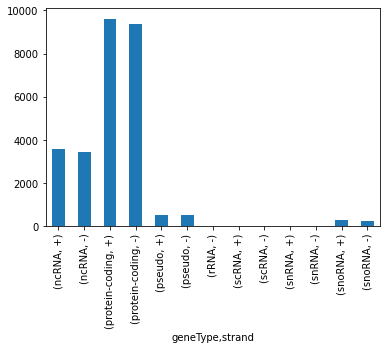

In [6]:
# by geneType and strand ...
genes_df.groupby(["geneType","strand"]).size().plot.bar()

### merging RNA-seq expression data with our gene annotation ...

In [7]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

,Id,12
0,MIR941-2,MIR941-2
3,TTTY1B,TTTY1B
5,F8A1,F8A1
8,C9orf16,C9orf16
9,CXorf56,CXorf56


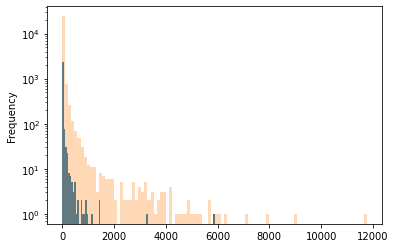

In [11]:
yyy = pd.merge(
    rsem_df,
    genes_df,
    how = 'left',
    left_on="Id",
    right_on="geneName"
)

yyy[yyy.isna().any(axis=1)]["rsem.out.S442_NT"].plot.hist(log=True,bins=100)
yyy["rsem.out.S442_NT"].plot.hist(log=True,bins=100,alpha=0.3)

display(pd.merge(
    yyy[yyy.isna().any(axis=1)]["Id"].reset_index(drop=True),
    pd.read_csv("./gene_annot_data/hg19/refGene_sorted",sep="\t",header=None)[12],
    how="inner",
    left_on="Id",
    right_on=12
).drop_duplicates().head(5))
# pd.read_csv("./gene_annot_data/hg19/refGene_sorted",sep="\t",header=None)[12]


### after "filtering" our list of genes we are left with ~ 27k of them, and let's get to extracting TSS/TTS and other useful info

In [12]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd"]

pgenes_df =  genes_df[ genes_df["strand"] == "+" ][tx_cols].reset_index(drop=True)
mgenes_df =  genes_df[ genes_df["strand"] == "-" ][tx_cols].reset_index(drop=True)

#### carefully extract TSS from the genes, considering their orientation, and possible duplications ...

In [14]:
pTSS = pgenes_df.copy()
mTSS = mgenes_df.copy()
# after copying, pTSS and mTSS are dataframes that have chr, txStart, txEnd  of the
# transcripts, that we could modify as we please ...

# for genes on p-strand, we keep txStart, and modify txEnd to be ~several bp downstream:
pTSS["txEnd"] = pTSS["txStart"] + 1
pTSS["strand"] = "+"
# report how many TSS were duplicated here:
print(f" there are {pTSS.duplicated().sum()} duplicated pTSSs ...")
pTSS = pTSS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(pTSS)} +TSSs to work with...")

# for genes on m-strand, we keep txEnd, and modify txStart to be ~several bp downstream (relative to the gene):
mTSS["txStart"] = mTSS["txEnd"] - 1
mTSS["strand"] = "-"
# report how many TSS were duplicated here:
print(f" there are {mTSS.duplicated().sum()} duplicated mTSSs ...")
mTSS = mTSS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(mTSS)} -TSSs to work with...")

# after modifying pTSS and mTSS separately - let's bring them back together ...
TSS = pd.concat([pTSS,mTSS]).reset_index(drop=True)
print(f"there are still {TSS.duplicated(subset=tx_cols).sum()} duplicated TSSs ... drop em")
TSS = TSS.drop_duplicates(subset=tx_cols).reset_index(drop=True)
print(f"finally there are {len(TSS)} -TSSs to work with...")
# we save them in the other notebook ...

 there are 66 duplicated pTSSs ...
finally there are 13921 +TSSs to work with...
 there are 58 duplicated mTSSs ...
finally there are 13476 -TSSs to work with...
there are still 1 duplicated TSSs ... drop em
finally there are 27396 -TSSs to work with...


#### carefully extract TTS (aka 3' end of the gene ) from the list of genes, considering their orientation, and possible duplications ...

In [15]:
pTTS = pgenes_df.copy()
mTTS = mgenes_df.copy()
# after copying, pTTS and mTTS are dataframes that have chr, txStart, txEnd  of the
# transcripts, that we could modify as we please ...

# for genes on p-strand, we keep txEnd, and modify txStart to be ~several bp upstream:
pTTS["txStart"] = pTTS["txEnd"] - 1
pTTS["strand"] = "+"
# report how many TTS were duplicated here:
print(f" there are {pTTS.duplicated().sum()} duplicated pTTSs ...")
pTTS = pTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(pTTS)} +TTSs to work with...")

# for genes on m-strand, we keep txStart, and modify txEnd to be ~several bp upstream (relative to the gene):
mTTS["txEnd"] = mTTS["txStart"] + 1
mTTS["strand"] = "-"
# report how many TTS were duplicated here:
print(f" there are {mTTS.duplicated().sum()} duplicated mTTSs ...")
mTTS = mTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(mTTS)} -TTSs to work with...")

# after modifying pTTS and mTTS separately - let's bring them back together ...
TTS = pd.concat([pTTS,mTTS]).reset_index(drop=True)
print(f"there are still {TTS.duplicated(subset=tx_cols).sum()} duplicated TTSs ... drop em")
TTS = TTS.drop_duplicates(subset=tx_cols).reset_index(drop=True)
print(f"finally there are {len(TTS)} -TTSs to work with...")
# we save them in the other notebook ...

 there are 120 duplicated pTTSs ...
finally there are 13867 +TTSs to work with...
 there are 68 duplicated mTTSs ...
finally there are 13466 -TTSs to work with...
there are still 2 duplicated TTSs ... drop em
finally there are 27331 -TTSs to work with...


In [16]:
# !scp allTTS_wstrand.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp allTSS_wstrand.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTSS-13412-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTSS-NO-CTCF-8849-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp activeTTS_wstrand.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTTS-withoutH3K4-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
# !scp ActiveTTS-withoutH3K4-NO-CTCF-10933-1bp.bed ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

### Let's get TTS corresponding to active TSSs
using our `ActiveTSS-13412-1bp.bed` file , and our main `gene_df` "database"

also we need to do this for `ActiveTSS-12216-1bp_HCT116_HAP1.bed` file - list of TSS active between HCT116 and HAP1 ...

In [32]:
# fname = "ActiveTSS-13412-1bp.bed"
fname = "ActiveTSS-12113-1bp_HCT116_HAP1.bed"
act_tss_df = bioframe.read_table(
    fname,
    names=["chrom","start","end","strand"]
)
act_tss_df = act_tss_df.sort_values(["chrom","start"])
act_tss_df = act_tss_df.reset_index(drop=True)

In [33]:
# Find "active genes" corresponding to our active TSS - simply by overlapping TSS and with the genes
active_genes_df = bioframe.overlap(
    act_tss_df,
    genes_df,
    how="left",
    cols2=tx_cols,
    suffixes=('2', '')
)
active_genes_df = active_genes_df.astype(
    {'start2':int,
     'end2':int,
     'txStart':int,
     'txEnd':int,
     'citationCount':int,
     'cdsStart':int,
     'cdsEnd':int,
    }
)
# active_genes_df - they are good, but there are plenty of duplicates - i.e. same transcripts
# but it's ok - since we are going to drop_duplicates for TTS anyways ...
display(active_genes_df.head(2))
print(f'Number of duplicated genes among the list of active ones {active_genes_df.duplicated(["chr","txStart","txEnd"]).sum()} - why?')

,chrom2,start2,end2,strand2,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,chr1,762970,762971,+,643837.0,chr1,762970,794826,LINC01128,6,+,union_643837,ncRNA,long intergenic non-protein coding RNA 1128,794826,794826,"762970,763177,764382,776579,783033,787306,7880...","763155,763229,764484,778984,783186,787490,7881..."
1,chr1,859302,859303,+,148398.0,chr1,859302,879954,SAMD11,14,+,union_148398,protein-coding,sterile alpha motif domain containing 11,859811,879533,"859302,861110,861301,865534,866418,871151,8744...","860328,861180,861393,865716,866469,871276,8745..."


Number of duplicated genes among the list of active ones 1865 - why?


#### get to extracting TTS, corresponding to the active TSS (active genes) ...

In [34]:
# columns needed for TSS/act_TTS bed files output:
act_pgenes_df =  active_genes_df[ active_genes_df["strand"] == "+" ][tx_cols].reset_index(drop=True)
act_mgenes_df =  active_genes_df[ active_genes_df["strand"] == "-" ][tx_cols].reset_index(drop=True)

act_pTTS = act_pgenes_df.copy()
act_mTTS = act_mgenes_df.copy()
# after copying, act_pTTS and act_mTTS are dataframes that have chr, txStart, txEnd  of the
# transcripts, that we could modify as we please ...

# for genes on p-strand, we keep txEnd, and modify txStart to be ~several bp upstream:
act_pTTS["txStart"] = act_pTTS["txEnd"] - 1
act_pTTS["strand"] = "+"
# report how many act_TTS were duplicated here:
print(f" there are {act_pTTS.duplicated().sum()} duplicated active pTTSs ...")
act_pTTS = act_pTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(act_pTTS)} active +TTSs to work with...")

# for genes on m-strand, we keep txStart, and modify txEnd to be ~several bp upstream (relative to the gene):
act_mTTS["txEnd"] = act_mTTS["txStart"] + 1
act_mTTS["strand"] = "-"
# report how many act_TTS were duplicated here:
print(f" there are {act_mTTS.duplicated().sum()} duplicated active mTTSs ...")
act_mTTS = act_mTTS.drop_duplicates().reset_index(drop=True)
print(f"finally there are {len(act_mTTS)} active -TTSs to work with...")

# after modifying act_pTTS and act_mTTS separately - let's bring them back together ...
act_TTS = pd.concat([act_pTTS,act_mTTS]).reset_index(drop=True)
print(f"there are still {act_TTS.duplicated(subset=tx_cols).sum()} duplicated active TTSs ... drop em")
act_TTS = act_TTS.drop_duplicates(subset=tx_cols).reset_index(drop=True)
print(f"finally there are {len(act_TTS)} active-TTSs to work with...")

# DROP IT !
act_TTS.to_csv("activeTTS_HCT116-HAP1_wstrand.bed",index=False,header=None,sep="\t")


 there are 1015 duplicated active pTTSs ...
finally there are 6246 active +TTSs to work with...
 there are 924 duplicated active mTTSs ...
finally there are 6091 active -TTSs to work with...
there are still 2 duplicated active TTSs ... drop em
finally there are 12335 active-TTSs to work with...
